# Extended inference

This demo shows the following inference options:

- big data inference
- iterable data load and inference
- labels passing

We will generage wyth `pyspark` a big dataset with transactions and other fields.

Since the dataset is large, we will use an iterable dataset to save memory and enable data loading and GPU output in parallel.

We don't need only embeddings. We need them with user_id, target, labels and other fields. We should keep it together for large iterable dataset.

## Data load

We will use real transactions to generate our fake dataset

In [1]:
import os

if not os.path.exists('data/transactions_train.csv'):
    ! mkdir -p data
    ! curl -OL https://storage.yandexcloud.net/di-datasets/age-prediction-nti-sbebank-2019.zip
    ! unzip -j -o age-prediction-nti-sbebank-2019.zip 'data/*.csv' -d data
    ! mv age-prediction-nti-sbebank-2019.zip data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  239M  100  239M    0     0  11.1M      0  0:00:21  0:00:21 --:--:-- 11.3M
Archive:  age-prediction-nti-sbebank-2019.zip
  inflating: data/test.csv           
  inflating: data/small_group_description.csv  
  inflating: data/train_target.csv   
  inflating: data/transactions_train.csv  
  inflating: data/transactions_test.csv  


# Data generation

In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [3]:
spark_conf = SparkConf()
spark_conf.setMaster("local[8]").setAppName("pyspark_data_generation")
spark_conf.set("spark.executor.memory", "32g")
spark_conf.set("spark.executor.memoryOverhead", "4g")
spark_conf.set("spark.driver.memory", "32g")
spark_conf.set("spark.driver.memoryOverhead", "4g")
spark_conf.set("spark.local.dir", "./spark_local_dir")

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

22/06/29 15:55:28 WARN Utils: Your hostname, vm2 resolves to a loopback address: 127.0.1.1; using 192.168.0.6 instead (on interface ens192)
22/06/29 15:55:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/06/29 15:55:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/06/29 15:55:29 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [4]:
spark

In [5]:
import random
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
df_real_trx = spark.read.csv('data/transactions_train.csv', header=True) \
    .select('trans_date', 'small_group', F.col('amount_rur').cast('float'))
df_real_trx.limit(5).toPandas()

,trans_date,small_group,amount_rur
0,6,4,71.462997
1,6,35,45.016998
2,8,11,13.887000
3,9,11,15.983000
4,10,11,21.341000


In [8]:
real_trx_count = df_real_trx.count()
real_trx_count

26450577

In [9]:
USER_CNT = 1e6
TOTAL_TRX_FOR_GENERATE = 800 * USER_CNT

In [10]:
df_generated = df_real_trx.sample(fraction=TOTAL_TRX_FOR_GENERATE / real_trx_count, withReplacement=True)
df_generated = df_generated.repartition(200)

In [11]:
df_generated = df_generated.withColumn('user_id', F.concat(F.lit('u_'), F.floor(F.rand() * USER_CNT)))

In [12]:
df_generated = df_generated.withColumn('event_time', F.rand())

In [13]:
df_generated.limit(5).toPandas()

,trans_date,small_group,amount_rur,user_id,event_time
0,41,21,151.056000,u_747178,0.954769
1,401,34,5.866000,u_695101,0.929234
2,504,47,23.871000,u_434036,0.973693
3,673,1,22.753000,u_994207,0.964114
4,87,83,146.634003,u_500597,0.379053


In [14]:
%%time
df_generated.write.parquet('df_generated.parquet', mode='overwrite')
df_generated = spark.read.parquet('df_generated.parquet')

CPU times: user 130 ms, sys: 52.8 ms, total: 183 ms
Wall time: 4min 4s


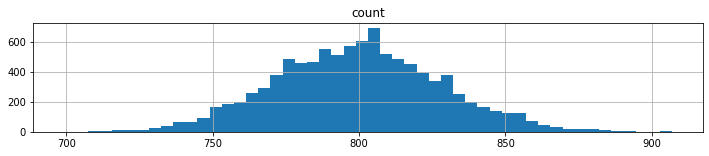

CPU times: user 583 ms, sys: 929 ms, total: 1.51 s
Wall time: 1min 5s


In [15]:
%%time
df_generated.groupby('user_id').count().select('count') \
.sample(True, fraction=1e4 / USER_CNT).toPandas().hist(bins=50, figsize=(12, 2))
plt.show()

In [16]:
from ptls.data_preprocessing import PysparkDataPreprocessor

preprocessor = PysparkDataPreprocessor(
    col_id='user_id',
    cols_event_time='event_time',
    time_transformation='none',
    cols_category=["trans_date", "small_group"],
    cols_log_norm=[],
    cols_identity=["amount_rur"],
    print_dataset_info=False,
)

In [17]:
%%time
df_gen_features = preprocessor.fit_transform(df_generated)

22/06/29 16:03:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/29 16:03:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/29 16:03:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/06/29 16:03:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/29 16:03:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/29 16:03:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/29 16:03:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/06/29 16:03:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/29 16:03:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/29 16:03:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/06/29 16:03:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/29 16:03:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/29 16:03:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/29 16:03:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
CPU times: user 201 ms, sys: 128 ms, total: 329 ms
Wall time: 19 s


In [18]:
df_gen_features = df_gen_features.withColumn('target', F.round(F.rand()).cast('int'))

In [19]:
%%time
df_gen_features.write.parquet('df_gen_features.parquet', mode='overwrite')

22/06/29 16:12:14 WARN MemoryStore: Not enough space to cache rdd_79_136 in memory! (computed 68.2 MiB so far)
22/06/29 16:12:14 WARN BlockManager: Persisting block rdd_79_136 to disk instead.


CPU times: user 376 ms, sys: 62.5 ms, total: 439 ms
Wall time: 11min 5s


In [1]:
!du -sh df_gen_features.parquet

9.5G	df_gen_features.parquet


In [21]:
spark.stop()

In [22]:
preprocessor.get_category_sizes()

{'trans_date': 730, 'small_group': 202}

# Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import torch
import pytorch_lightning as pl

from tqdm.auto import tqdm

## Data for inferenfce

In [7]:
from functools import partial
from ptls.data_load.datasets import ParquetDataset, ParquetFiles
from ptls.data_load.iterable_processing import ISeqLenLimit
from ptls.data_load.utils import collate_feature_dict

In [8]:
iterable_inference_dataset = ParquetDataset(
    data_files=ParquetFiles('df_gen_features.parquet').data_files,
    i_filters=[
        ISeqLenLimit(max_seq_len=2000), 
    ],
)
next(iter(iterable_inference_dataset))

{'user_id': 'u_100173',
 'trans_date': tensor([471, 430, 185, 616, 416, 609, 149, 595, 718, 284, 391, 158, 581, 699,
         379, 457, 504, 704, 694, 306, 469, 294, 358, 104, 168, 726, 334, 598,
         399, 397, 226,  88, 548, 413, 153, 490, 464, 144, 454, 171, 492, 390,
         257, 387,  70, 502, 232, 107, 403,  38, 280, 159, 623, 472, 523, 261,
         343, 393,  79, 281,  60,  82, 554, 276, 284, 161,  35, 221,  51,  44,
          89, 497, 280, 141, 407,  20, 651,  56, 300, 309, 458,  63, 100, 325,
         177, 131, 411, 453,  41, 392, 473, 517, 728, 312, 223, 163, 593, 348,
         538, 231, 228, 615, 188, 162, 529, 159, 291, 182,  86,  76, 614, 115,
         372, 175, 555, 224,   8, 479, 286, 144, 139, 127, 330, 682, 217, 379,
         616, 486, 220, 399, 152, 218, 111, 675, 124, 662, 254, 345, 618, 466,
         104, 559, 699, 235, 186,  58, 287, 497, 149, 123, 704,  12, 582,  64,
         331, 629,  14, 410,  55, 602, 101, 539,  65, 617, 410,  92,  15, 386,
          77, 

In [ ]:
%%time
for rec in tqdm(iterable_inference_dataset):
    pass

In [9]:
inference_dl = torch.utils.data.DataLoader(
    dataset=iterable_inference_dataset,
    collate_fn=partial(collate_feature_dict, only_tensors=False),
    shuffle=False,
    batch_size=1000,
    num_workers=12,
)
next(iter(inference_dl)).payload

{'user_id': array(['u_100173', 'u_100319', 'u_100641', 'u_101300', 'u_101680',
        'u_102378', 'u_102623', 'u_102630', 'u_10270', 'u_10290',
        'u_103062', 'u_10341', 'u_104021', 'u_104027', 'u_104059',
        'u_104186', 'u_104524', 'u_104751', 'u_104941', 'u_1051',
        'u_105541', 'u_105590', 'u_105777', 'u_105901', 'u_105915',
        'u_106161', 'u_106447', 'u_106565', 'u_106811', 'u_106945',
        'u_10712', 'u_107123', 'u_10726', 'u_10731', 'u_107549',
        'u_108468', 'u_108475', 'u_108574', 'u_108639', 'u_108647',
        'u_108733', 'u_10909', 'u_109139', 'u_109210', 'u_109243',
        'u_109369', 'u_109416', 'u_109500', 'u_10952', 'u_10954',
        'u_109607', 'u_109666', 'u_110252', 'u_110405', 'u_110440',
        'u_110466', 'u_110965', 'u_111464', 'u_1115', 'u_111552',
        'u_111669', 'u_111673', 'u_111698', 'u_111798', 'u_111897',
        'u_1123', 'u_112312', 'u_112923', 'u_112992', 'u_113182',
        'u_113279', 'u_113305', 'u_113327', 'u_11363

In [10]:
%%time
for rec in tqdm(inference_dl):
    pass

0it [00:00, ?it/s]

CPU times: user 1.66 s, sys: 2.16 s, total: 3.81 s
Wall time: 11.2 s


## Model

In [20]:
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.inference_module import InferenceModule

In [21]:
# random model in demo
# use trained model for real usage
seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(
        embeddings={
            'trans_date': {'in': 800, 'out': 32}, 
            'small_group': {'in': 200, 'out': 32},
        },
        numeric_values={'amount_rur': 'log'},
    ),
    hidden_size=256,
)

In [25]:
model = InferenceModule(model=seq_encoder, pandas_output=True, model_out_name='emb')

## Iterable inference

In [26]:
predict = pl.Trainer(gpus=1).predict(model, inference_dl)

/home/kireev/pipenv_envs/pytorch-lifestream-KxQJF1XF/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [27]:
predict[0]

,user_id,target,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,...,emb_0246,emb_0247,emb_0248,emb_0249,emb_0250,emb_0251,emb_0252,emb_0253,emb_0254,emb_0255
0,u_100173,0,0.328473,-0.041245,-0.147720,-0.002845,0.312168,0.037303,0.393641,0.022853,...,0.245151,0.066214,0.114227,0.225143,-0.084436,-0.180903,0.151792,-0.016717,-0.045071,-0.450113
1,u_100319,1,0.238145,0.193970,0.147273,-0.071919,0.074686,0.035626,0.112520,0.161449,...,0.178949,-0.139139,-0.207757,0.096016,-0.208386,0.182478,0.149600,0.219091,0.176602,-0.064075
2,u_100641,0,0.143543,0.121639,0.114885,0.173832,0.040646,0.066611,0.395496,0.052862,...,-0.090137,0.099573,-0.015959,0.011106,0.024636,-0.159012,0.278187,-0.296812,0.023095,-0.229518
3,u_101300,0,0.343369,-0.009261,0.120017,-0.194460,0.283304,-0.105037,0.307335,0.112195,...,0.210593,0.054962,-0.185053,0.062762,-0.349481,0.320525,0.327023,0.033048,0.308533,-0.242240
4,u_101680,0,0.110057,0.382863,-0.000882,0.061691,0.146916,0.199971,0.349496,0.323261,...,0.116795,0.223603,-0.077991,0.112117,-0.079900,-0.158205,0.314365,0.177920,-0.022189,-0.025890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,u_283239,0,0.354072,0.092454,0.040970,0.359921,0.082783,-0.028416,0.233225,0.067131,...,0.273239,0.087559,-0.060689,-0.005826,-0.274094,0.036808,0.256658,-0.059108,0.258162,-0.224057
996,u_283484,0,-0.117449,-0.052256,0.248940,0.008882,-0.080366,0.177775,0.151045,0.249522,...,0.131372,0.155122,-0.190573,-0.045708,-0.195466,0.071780,0.132462,0.121086,0.095586,-0.275485
997,u_283575,1,0.072493,0.324913,-0.086386,0.028520,0.317191,0.390053,0.052547,-0.166408,...,0.067687,0.117783,0.166526,0.138490,-0.157028,-0.099661,0.157664,-0.371687,0.308954,-0.428635
998,u_28365,0,0.210521,0.146216,-0.280463,0.035839,-0.006321,0.108624,0.317275,-0.093777,...,-0.104618,-0.006103,0.055233,0.254883,-0.164119,-0.006468,0.427857,0.034468,0.251725,-0.168443


In [28]:
full_predict = pd.concat(predict, axis=0)
full_predict.head()

,user_id,target,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,...,emb_0246,emb_0247,emb_0248,emb_0249,emb_0250,emb_0251,emb_0252,emb_0253,emb_0254,emb_0255
0,u_100173,0,0.328473,-0.041245,-0.147720,-0.002845,0.312168,0.037303,0.393641,0.022853,...,0.245151,0.066214,0.114227,0.225143,-0.084436,-0.180903,0.151792,-0.016717,-0.045071,-0.450113
1,u_100319,1,0.238145,0.193970,0.147273,-0.071919,0.074686,0.035626,0.112520,0.161449,...,0.178949,-0.139139,-0.207757,0.096016,-0.208386,0.182478,0.149600,0.219091,0.176602,-0.064075
2,u_100641,0,0.143543,0.121639,0.114885,0.173832,0.040646,0.066611,0.395496,0.052862,...,-0.090137,0.099573,-0.015959,0.011106,0.024636,-0.159012,0.278187,-0.296812,0.023095,-0.229518
3,u_101300,0,0.343369,-0.009261,0.120017,-0.194460,0.283304,-0.105037,0.307335,0.112195,...,0.210593,0.054962,-0.185053,0.062762,-0.349481,0.320525,0.327023,0.033048,0.308533,-0.242240
4,u_101680,0,0.110057,0.382863,-0.000882,0.061691,0.146916,0.199971,0.349496,0.323261,...,0.116795,0.223603,-0.077991,0.112117,-0.079900,-0.158205,0.314365,0.177920,-0.022189,-0.025890


In [29]:
full_predict.shape

(1000000, 258)

In [30]:
full_predict.to_parquet('full_predict.parquet')

In [31]:
!du -sh full_predict.parquet

1.2G	full_predict.parquet
